In [2]:
# imports
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [12]:
data = pd.read_csv('initial_train.csv')
data.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [18]:
data.shape[0]

1804874

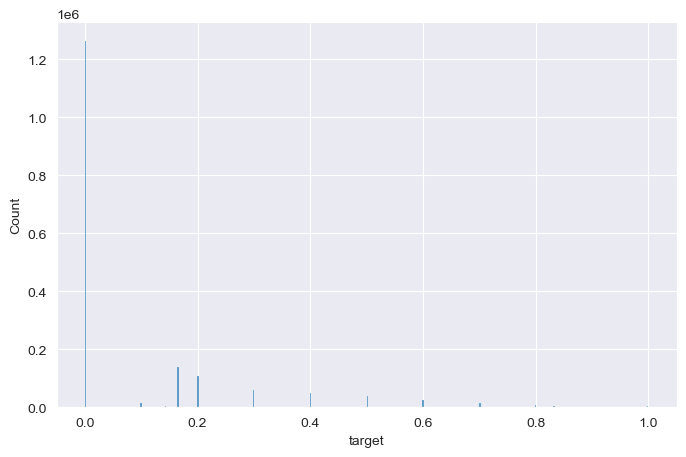

In [227]:
plt.figure(figsize=(8, 5))
sns.histplot(data.target)
plt.show()

классификация комментариев будет бинарной, поэтому переведем переменную `target` в `bin_target` по порогу 0.5

In [19]:
data['bin_target'] = 0
data.loc[data['target'] > 0.5, 'bin_target'] = 1
data.loc[data['target'] == 0.5, 'bin_target'] = -1

In [20]:
data.bin_target.value_counts(normalize=True)

 0    0.920031
 1    0.058973
-1    0.020996
Name: bin_target, dtype: float64

видим, что классы распределены неравномерно. удалим объекты с вероятностью 0.5, так как их классификация неоднозначна, тем более таких объектов меньше одного процента. 

In [21]:
data.drop(index=data[data.target == 0.5].index, inplace=True)

In [22]:
data.isna().sum()

id                                           0
target                                       0
comment_text                                 0
severe_toxicity                              0
obscene                                      0
identity_attack                              0
insult                                       0
threat                                       0
asian                                  1375284
atheist                                1375284
bisexual                               1375284
black                                  1375284
buddhist                               1375284
christian                              1375284
female                                 1375284
heterosexual                           1375284
hindu                                  1375284
homosexual_gay_or_lesbian              1375284
intellectual_or_learning_disability    1375284
jewish                                 1375284
latino                                 1375284
male         

есть пропуски, но они не сильно влияют на пайплайн обучения модели, так как в тестовых данных соответсвующих признаков нет

In [232]:
data.nunique()

id                                     1766978
target                                    2912
comment_text                           1743433
severe_toxicity                           1460
obscene                                   2416
identity_attack                           2292
insult                                    3041
threat                                    2052
asian                                      118
atheist                                     82
bisexual                                    79
black                                      115
buddhist                                    59
christian                                  147
female                                     190
heterosexual                               116
hindu                                       72
homosexual_gay_or_lesbian                  113
intellectual_or_learning_disability         69
jewish                                     113
latino                                      98
male         

убираем дублирующиеся тексты

In [23]:
data.drop(data[data.duplicated(subset='comment_text')].index, inplace=True)

In [234]:
data.describe()

,id,target,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,...,article_id,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,bin_target
count,1.743433e+06,1.743433e+06,1.743433e+06,1.743433e+06,1.743433e+06,1.743433e+06,1.743433e+06,387801.000000,387801.000000,387801.000000,...,1.743433e+06,1.743433e+06,1.743433e+06,1.743433e+06,1.743433e+06,1.743433e+06,1.743433e+06,1.743433e+06,1.743433e+06,1.743433e+06
mean,3.733760e+06,9.473320e-02,4.241513e-03,1.298826e-02,2.068145e-02,7.460769e-02,8.632335e-03,0.011910,0.003187,0.001827,...,2.811580e+05,2.792697e-01,4.415598e-02,1.088364e-01,2.451882e+00,5.833192e-01,6.123283e-03,1.416299e+00,8.719544e+00,6.019216e-02
std,2.445756e+06,1.902410e-01,2.201852e-02,6.302888e-02,7.442770e-02,1.704125e-01,4.728977e-02,0.086847,0.050020,0.025525,...,1.039524e+05,1.060431e+00,2.447707e-01,4.544698e-01,4.719988e+00,1.861957e+00,4.346226e-02,1.746028e+01,4.392520e+01,2.378426e-01
min,5.984800e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,2.006000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00
25%,7.953720e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,1.600630e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00
50%,5.221489e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,3.319910e+05,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00
75%,5.767707e+06,1.666667e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,...,3.661110e+05,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.000000e+00,0.000000e+00
max,6.334010e+06,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000,...,3.995410e+05,1.020000e+02,2.100000e+01,3.100000e+01,3.000000e+02,1.870000e+02,1.000000e+00,1.866000e+03,4.936000e+03,1.000000e+00


посмотрим на количество слов и символов в комментариях

In [24]:
data['sym_len'] = data.comment_text.apply(len)
data['word_len'] = data.comment_text.apply(lambda x: len(x.split()))

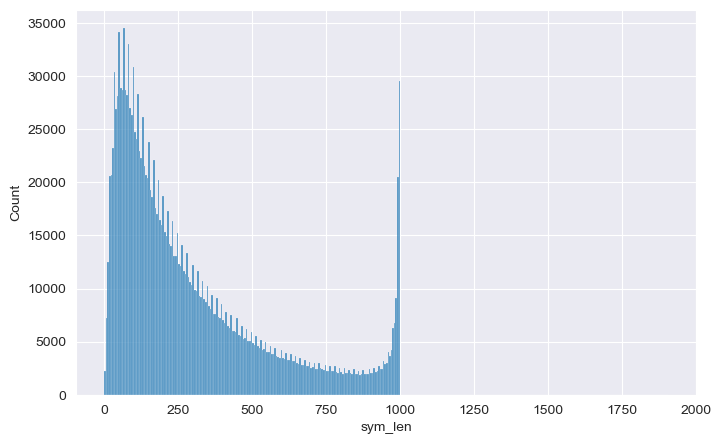

In [236]:
plt.figure(figsize=(8, 5))
sns.histplot(data.sym_len)
plt.show()

In [240]:
(data.sym_len > 1000).sum()

6

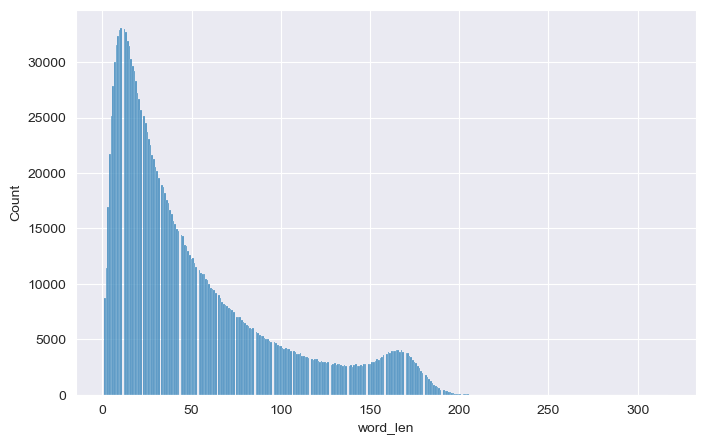

In [238]:
plt.figure(figsize=(8, 5))
sns.histplot(data.word_len)
plt.show()

In [241]:
(data.word_len > 200).sum()

239

удалим тяжелые хвосты, таких значений совсем немного

In [25]:
data.drop(index=data[data.word_len > 200].index, inplace=True)
data.drop(index=data[data.sym_len > 1000].index, inplace=True)

In [243]:
data.loc[data.bin_target==1, ['word_len', 'sym_len']].describe()

,word_len,sym_len
count,104933.000000,104933.000000
mean,44.456263,254.267523
std,39.868160,229.620452
min,1.000000,3.000000
25%,16.000000,91.000000
50%,31.000000,178.000000
75%,59.000000,336.000000
max,200.000000,1000.000000


In [244]:
data.loc[data.bin_target==0, ['word_len', 'sym_len']].describe()

,word_len,sym_len
count,1.638259e+06,1.638259e+06
mean,5.193514e+01,3.012590e+02
std,4.640426e+01,2.707504e+02
min,1.000000e+00,1.000000e+00
25%,1.700000e+01,9.600000e+01
50%,3.600000e+01,2.050000e+02
75%,7.300000e+01,4.210000e+02
max,2.000000e+02,1.000000e+03


средее количество слов и символов для токсичных и нетоксичных комментариев сильно не отличается

**sample smaller dataset**

так как обучаться на более, чем 1М данных очень затратно, в проекте будет использована только часть датасета. 
- 20k toxic and 20k nontoxic comments - train
- 10k toxic and 10k nontoxic comments - val
- 10k toxic and 10k nontoxic comments - test

внутри положительных и отрицательных классов объекты будут семплироваться в соотвествии с их вероятностями

остальные признаки, кроме текста, при обучении использоваться не будут, так как тогда неясно, как внедрять модель в прод, ведь никакой точечной разметки новых комментариев уже не будет

In [26]:
data['probs'] = 1 - data.target

In [27]:
n = 40000
df_pos = data[data.bin_target == 0].sample(n=n, weights=data.loc[data.bin_target == 0, 'probs'], random_state=42).reset_index().drop(columns='index')
df_neg = data[data.bin_target == 1].sample(n=n, weights=data.loc[data.bin_target == 1, 'probs'], random_state=42).reset_index().drop(columns='index')

In [28]:
df = pd.concat([df_pos, df_neg]).reset_index().drop(columns='index')
df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,bin_target,sym_len,word_len,probs
0,1066243,0.000000,".\n\n""Canada’s economy grew at a faster pace t...",0.000000,0.0,0.0,0.0,0.000000,NaN,NaN,...,0,0,0,0.0,0,5,0,143,23,1.000000
1,6224902,0.166667,Can't wait for Hi to get nuked! LOL,0.166667,0.0,0.0,0.0,0.166667,NaN,NaN,...,0,0,0,0.0,0,6,0,35,8,0.833333
2,5722540,0.000000,You really need it explained?,0.000000,0.0,0.0,0.0,0.000000,NaN,NaN,...,0,6,2,0.0,0,4,0,29,5,1.000000
3,5430843,0.400000,"Wish and wish, Dermot. The Rs are going to bac...",0.100000,0.1,0.0,0.4,0.000000,NaN,NaN,...,0,4,1,0.0,0,10,0,402,79,0.600000
4,585781,0.000000,And I want to add Thank-You Donald J Trump Wik...,0.000000,0.0,0.0,0.0,0.000000,NaN,NaN,...,0,7,0,0.0,0,4,0,90,17,1.000000


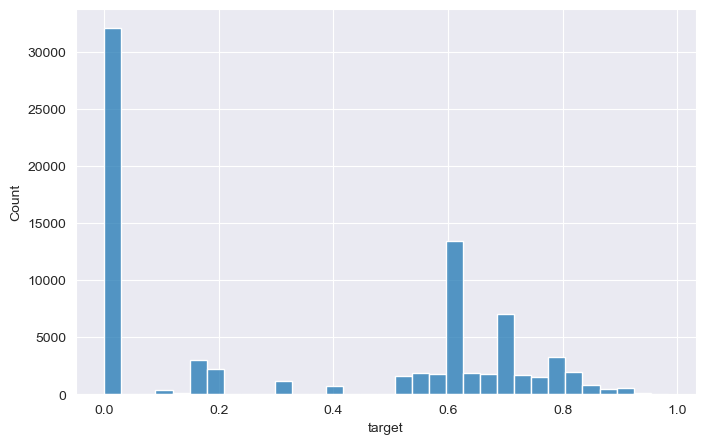

In [248]:
plt.figure(figsize=(8, 5))
sns.histplot(df.target)
plt.show()

In [29]:
df.bin_target.value_counts()

0    40000
1    40000
Name: bin_target, dtype: int64

#### text preparation

Воспользуемся библиотекой nltk, чтобы токенизировать комментарии и провести лемматизацию слов. Изначально все слова будут приведены к нижнему регистру. Лемматизация приводит слова к их нормальной форме, а стемминг довольно грубо отбрасывает части слов, поэтому будем использовать лемматизацию

In [30]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [31]:
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Xiaomi\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Xiaomi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Xiaomi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Xiaomi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [32]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [33]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [34]:
df['text'] = df.apply(lambda row: preprocess(row.comment_text), axis=1)

In [35]:
df[['target', 'bin_target', 'comment_text', 'text', 'sym_len', 'word_len']]

,target,bin_target,comment_text,text,sym_len,word_len
0,0.000000,0,".\n\n""Canada’s economy grew at a faster pace t...",canada economy grew faster pace anticipated fi...,143,23
1,0.166667,0,Can't wait for Hi to get nuked! LOL,ca wait hi get nuked lol,35,8
2,0.000000,0,You really need it explained?,really need explained,29,5
3,0.400000,0,"Wish and wish, Dermot. The Rs are going to bac...",wish wish dermot r going back idiotic stance t...,402,79
4,0.000000,0,And I want to add Thank-You Donald J Trump Wik...,want add donald j trump wikileaks everyone els...,90,17
...,...,...,...,...,...,...
79995,0.600000,1,Another dishonest write ups and appraisals of ...,another dishonest write ups appraisal liberali...,545,97
79996,0.557143,1,"This ""self-proclaimed Christian"" thinks Donald...",christian think donald shameful disgraceful pe...,97,13
79997,0.621212,1,We are being sold out by our liberal governmen...,sold liberal government welcome scum planet vo...,176,34
79998,0.700000,1,"Obama withstood the constant attacks well, as ...",obama withstood constant attack well leader wo...,106,16


#### analyzing train data

In [254]:
# del data

In [38]:
all_cols = df.columns
all_cols

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count', 'bin_target',
       'sym_len', 'word_len', 'probs', 'text'],
      dtype='object')

In [41]:
drop_cols = all_cols[8:32].tolist() + all_cols[34:35].tolist() + all_cols[43:45].tolist() + ['publication_id', 'article_id', 'id', 'rating']
df.drop(columns=drop_cols, inplace=True)

In [64]:
X_train_val, X_test, y_train_val, y_test = train_test_split(df, df.bin_target, test_size=0.25, random_state=42, stratify=df.bin_target)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=1/3, random_state=42, stratify=y_train_val)

In [43]:
len(y_train), len(y_val), len(y_test)

(40000, 20000, 20000)

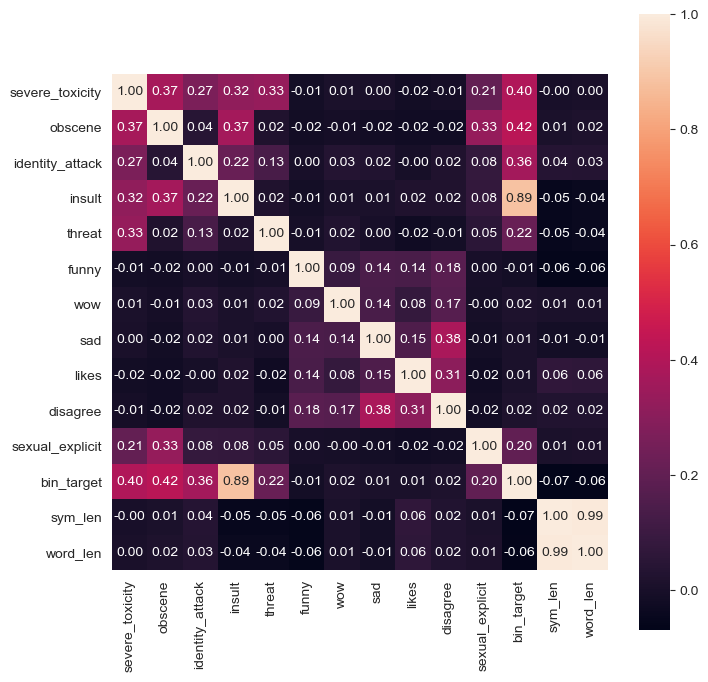

In [258]:
correlations = X_train.drop(columns=['target', 'probs', 'comment_text', 'created_date', 'text']).corr()
plt.figure(figsize=(8, 8))
sns.heatmap(correlations, square=True, annot=True, fmt='.2f')
plt.show()

видим, что признак "insult" сильно коррелирует с бинарным таргетом 

In [260]:
cols = ['severe_toxicity', 'obscene', 'identity_attack', 'insult',
        'threat', 'funny', 'wow', 'sad', 
        'likes', 'disagree', 'sexual_explicit']

In [261]:
X_train.loc[X_train.bin_target == 0, cols].describe()

,severe_toxicity,obscene,identity_attack,insult,threat,funny,wow,sad,likes,disagree,sexual_explicit
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.001853,0.004248,0.011619,0.031286,0.005290,0.283050,0.043550,0.109900,2.443250,0.581200,0.003323
std,0.015647,0.026884,0.048405,0.080276,0.030885,1.030139,0.238655,0.481595,4.602992,1.901443,0.026920
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
max,0.300000,0.445946,0.500000,0.500000,0.500000,34.000000,7.000000,14.000000,146.000000,57.000000,0.600000


In [262]:
X_train.loc[X_train.bin_target == 1, cols].describe()

,severe_toxicity,obscene,identity_attack,insult,threat,funny,wow,sad,likes,disagree,sexual_explicit
count,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,0.032055,0.117668,0.118225,0.56913,0.046456,0.259050,0.051700,0.117650,2.525150,0.644150,0.040411
std,0.046607,0.170920,0.186870,0.18304,0.126061,1.158667,0.266891,0.474573,5.110839,1.958676,0.124349
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.50000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.013889,0.056604,0.025000,0.60000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.046875,0.150000,0.140419,0.70000,0.014706,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
max,0.503185,1.000000,1.000000,1.00000,1.000000,95.000000,7.000000,9.000000,128.000000,72.000000,1.000000


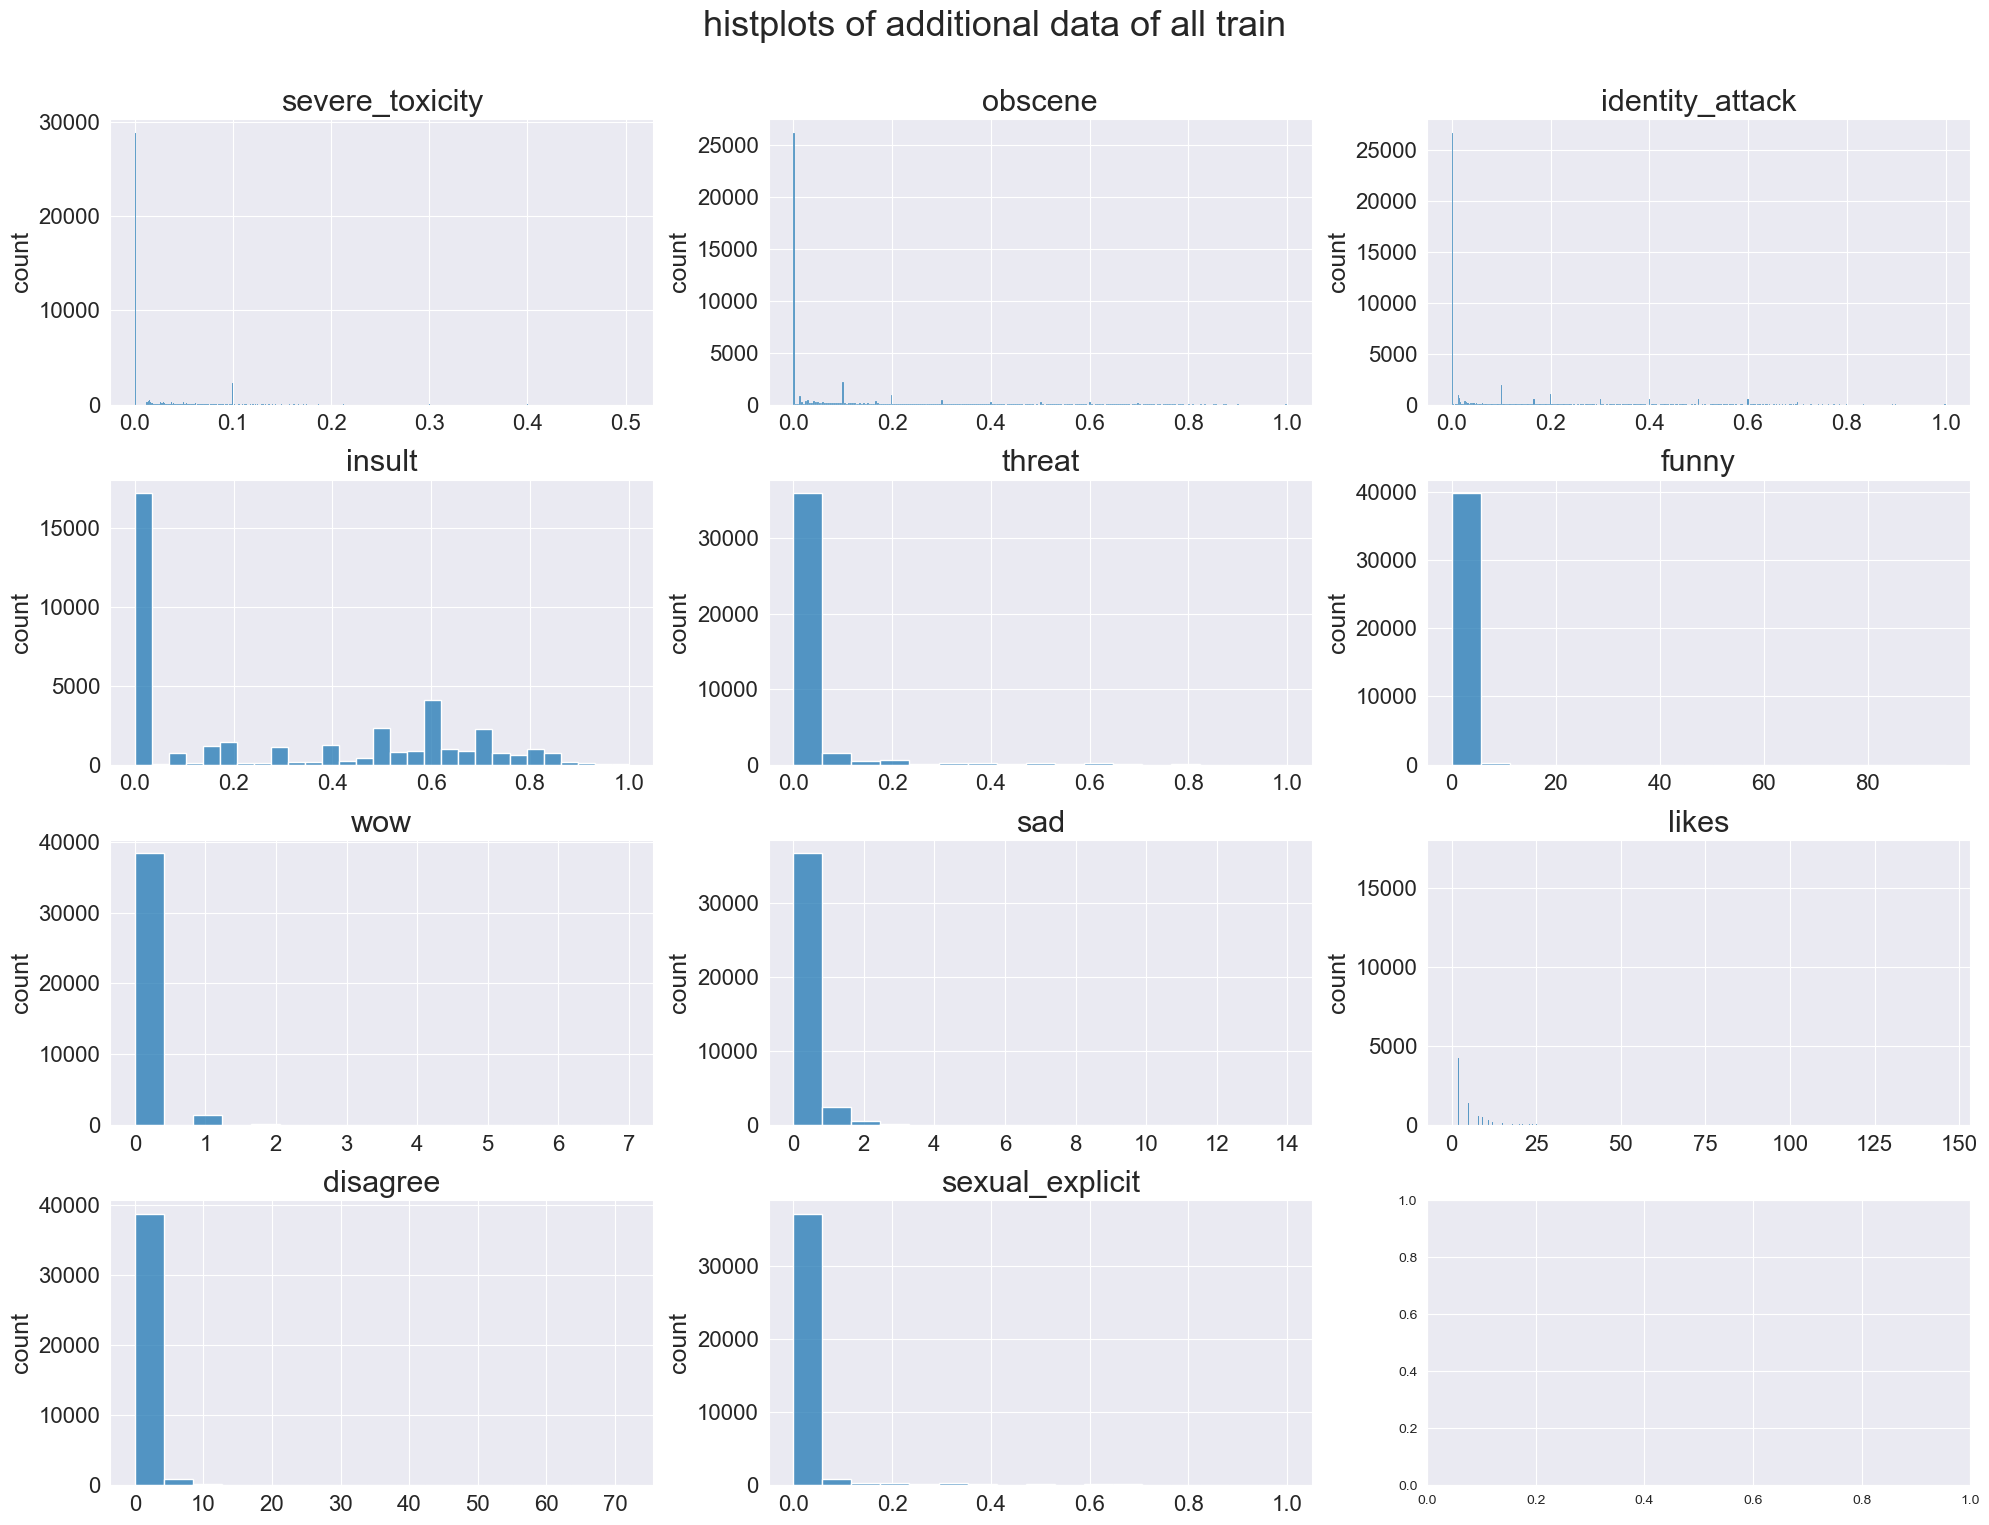

In [263]:
fig, axes = plt.subplots(4, 3, figsize = (20,16))
for ax, column in zip(axes.flatten(), cols):
    sns.histplot(X_train[column], palette='pastel', ax=ax)
    ax.set_title(f"{column}", fontsize = 22)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)
    ax.set_xlabel(None)
    ax.set_ylabel('count', fontsize = 18)
fig.suptitle('histplots of additional data of all train', fontsize = 26)
fig.tight_layout(rect = [0, 0.03, 1, 0.97])

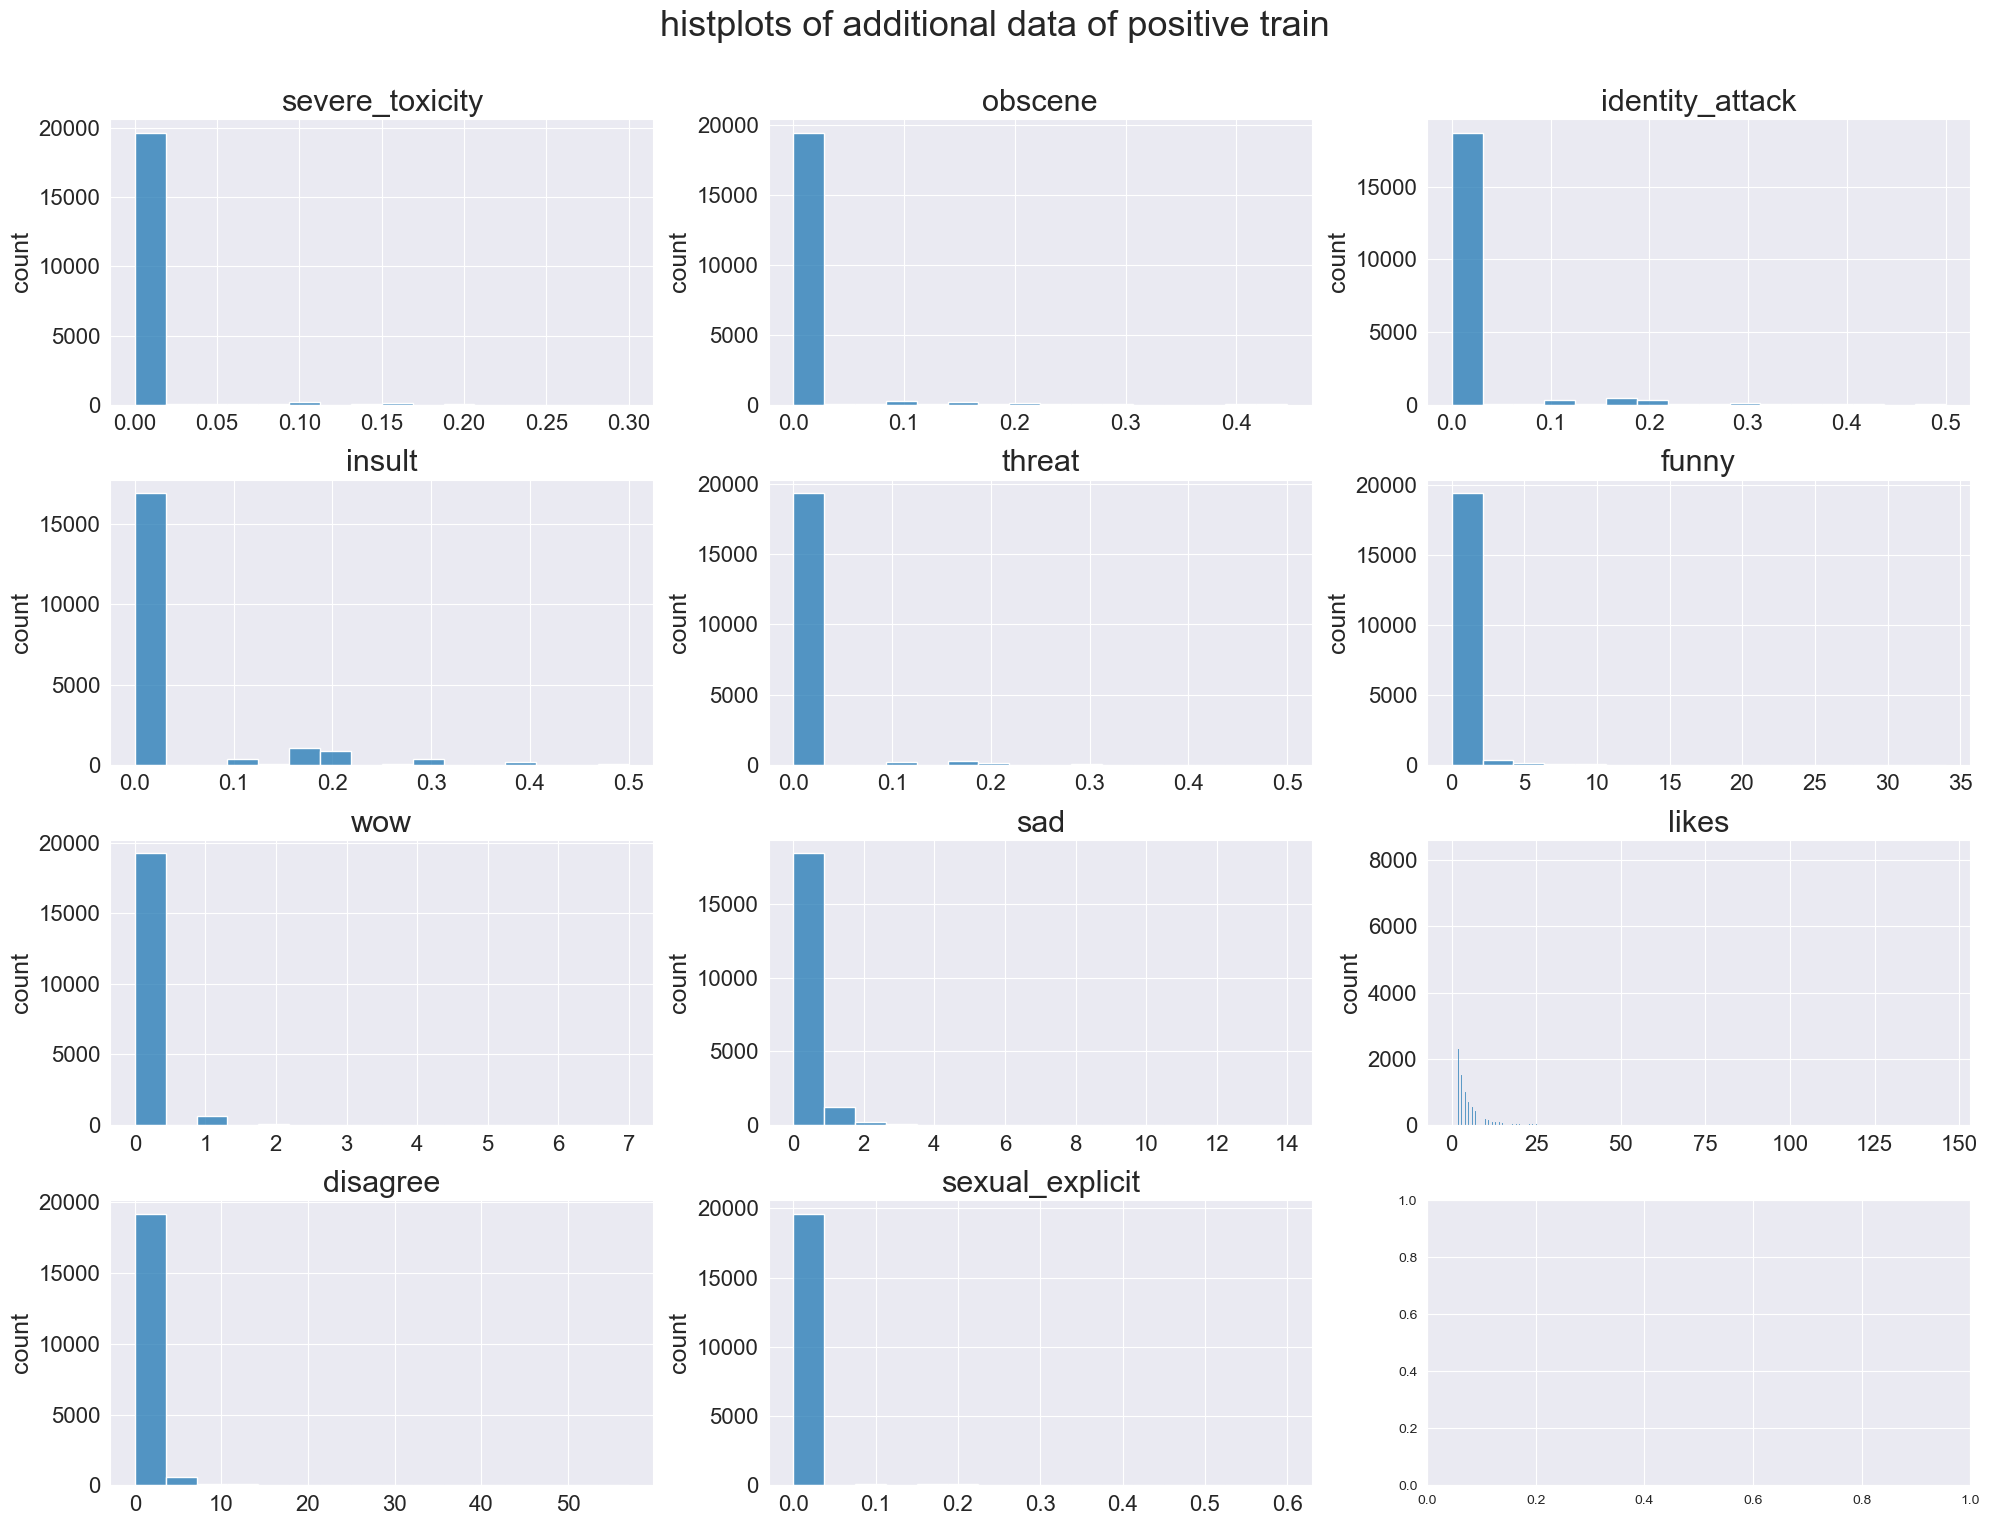

In [264]:
fig, axes = plt.subplots(4, 3, figsize = (20,16))
for ax, column in zip(axes.flatten(), cols):
    sns.histplot(X_train.loc[X_train.bin_target == 0, column], palette='pastel', ax=ax)
    ax.set_title(f"{column}", fontsize = 22)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)
    ax.set_xlabel(None)
    ax.set_ylabel('count', fontsize = 18)
fig.suptitle('histplots of additional data of positive train', fontsize = 26)
fig.tight_layout(rect = [0, 0.03, 1, 0.97])

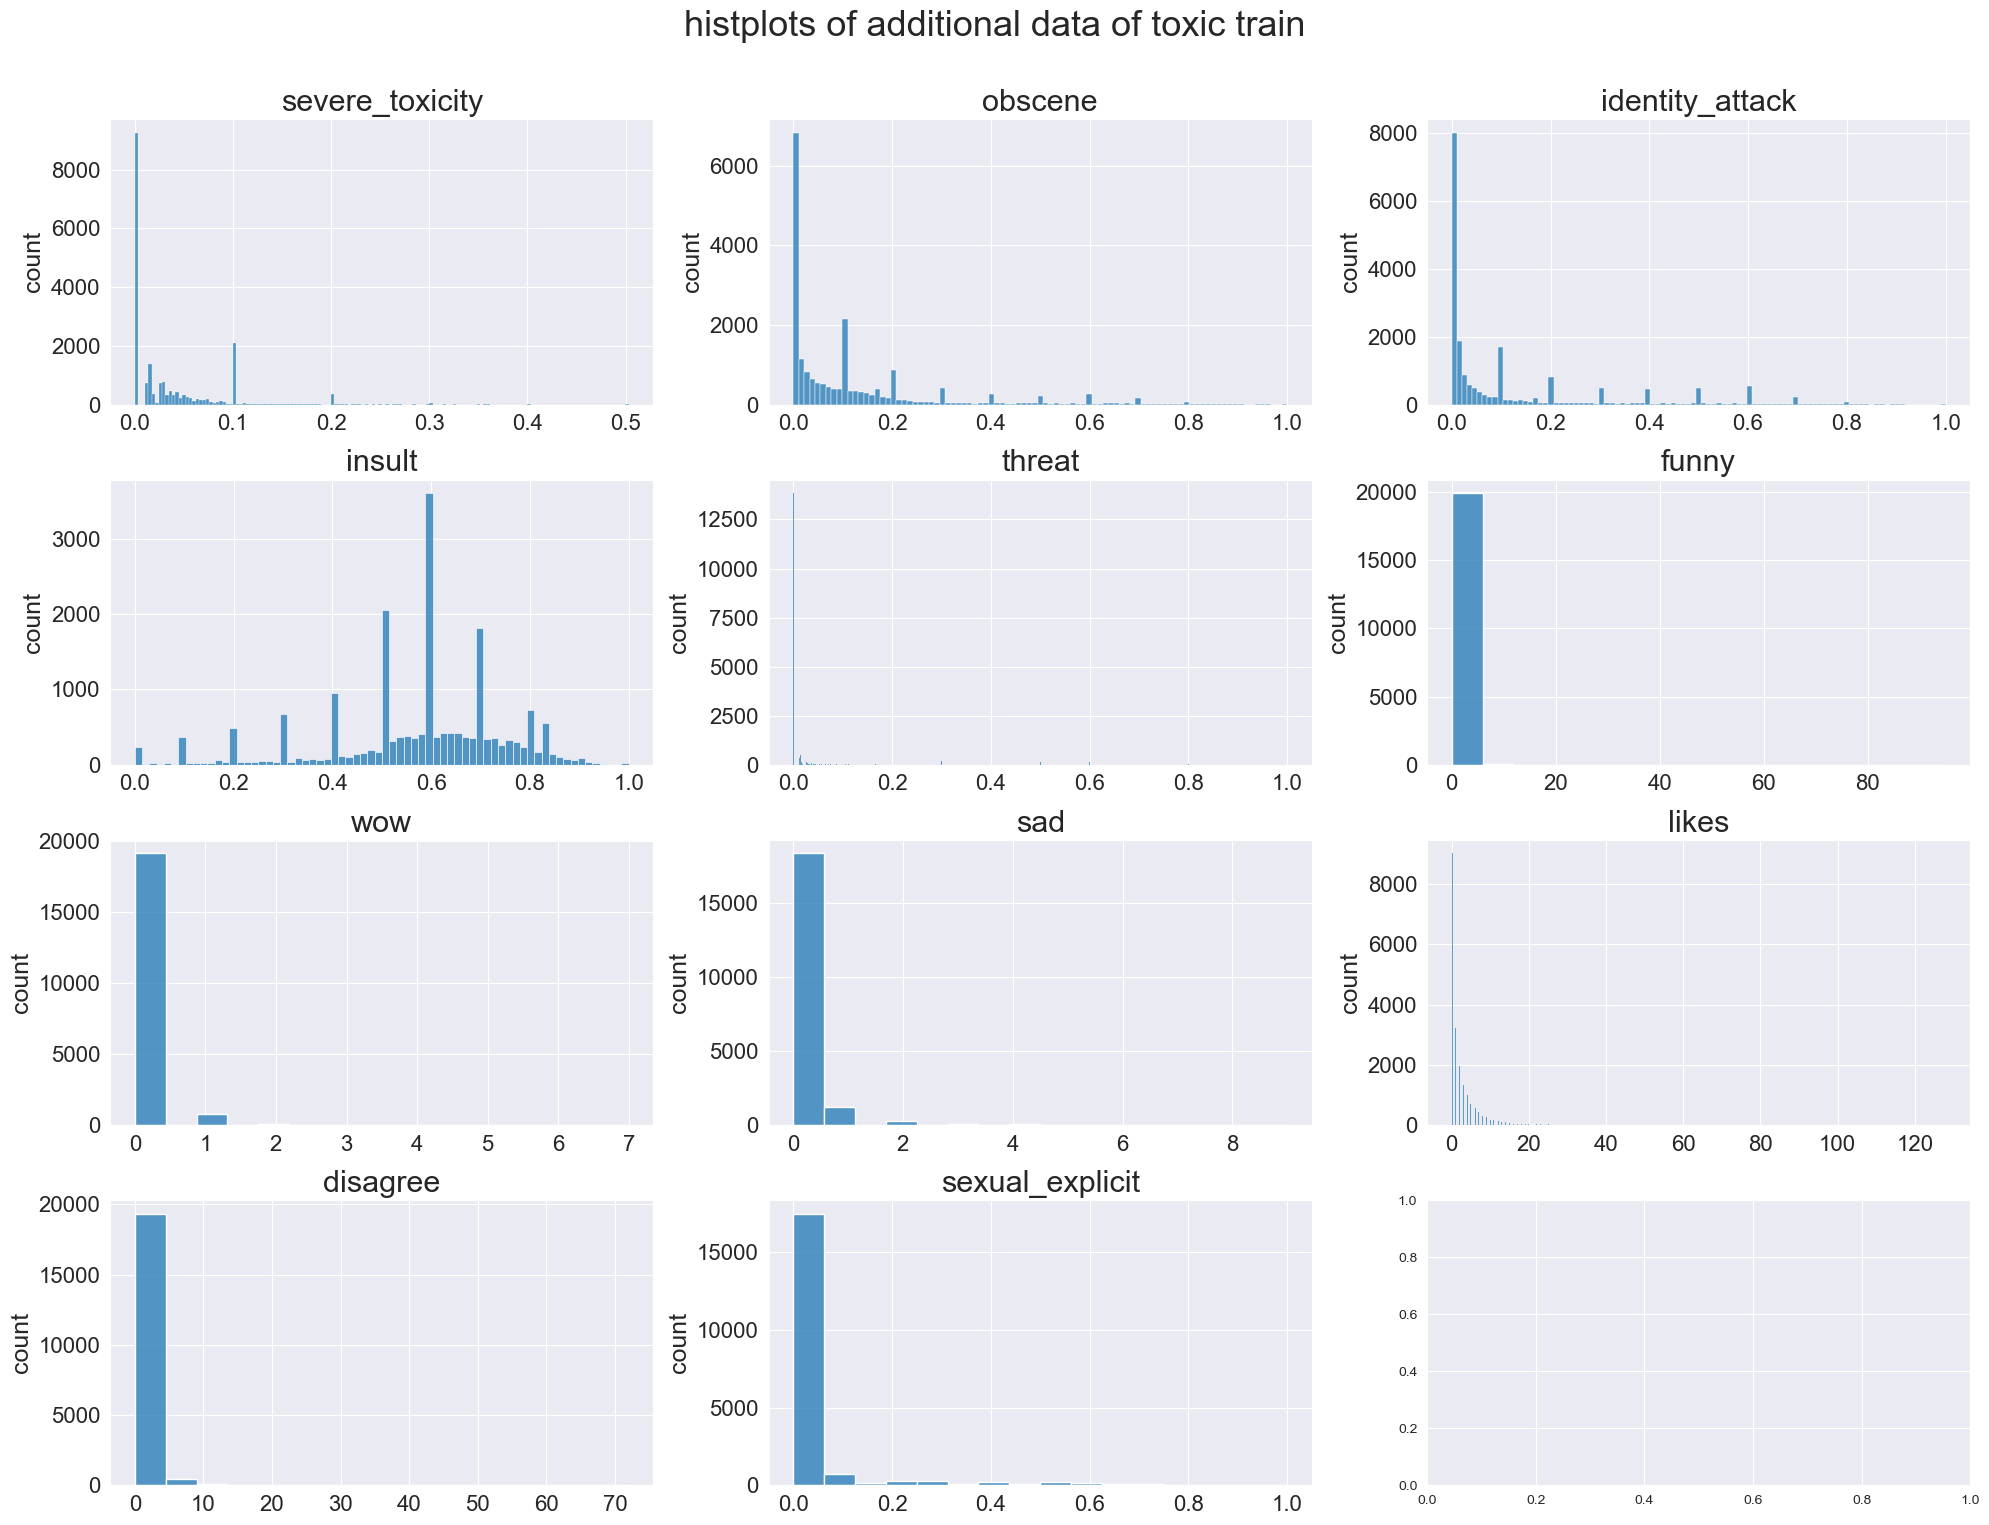

In [265]:
fig, axes = plt.subplots(4, 3, figsize = (20,16))
for ax, column in zip(axes.flatten(), cols):
    sns.histplot(X_train.loc[X_train.bin_target == 1, column], palette='pastel', ax=ax)
    ax.set_title(f"{column}", fontsize = 22)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 16)
    ax.set_xlabel(None)
    ax.set_ylabel('count', fontsize = 18)
fig.suptitle('histplots of additional data of toxic train', fontsize = 26)
fig.tight_layout(rect = [0, 0.03, 1, 0.97])

видно, что негативные признаки - "severe toxicity", "obscene", "identity attack", "insult", "threat", "sexual explicit" более ярко выражены в токсичных комментариях 

посчитаем наиболее часто встречающиеся слова в каждом из классов

In [276]:
def get_most_popular_words(X, n_top=25):
    cnt_vec = CountVectorizer(min_df=0.01)
    X_tr = cnt_vec.fit_transform(X)
    
    word2ids_cnt = cnt_vec.vocabulary_
    idx2word_cnt = [""] * len(word2ids_cnt)
    for word in word2ids_cnt:
        idx2word_cnt[word2ids_cnt[word]] = word
    
    counts = X_tr.sum(axis=0).tolist()[0]
    word_ids = np.argsort(counts)[::-1][:n_top]
    top_words = [(idx2word_cnt[i], counts[i]) for i in word_ids]
    df_top_words = pd.DataFrame(top_words)
    df_top_words.columns = ['feature', 'count']
    return df_top_words

In [279]:
get_most_popular_words(X_train.loc[X_train.bin_target == 1, 'text'], n_top=15)

,feature,count
0,trump,4617
1,wa,4026
2,people,3895
3,like,3633
4,ha,3031
5,would,2735
6,one,2730
7,get,2546
8,stupid,2233
9,think,1818


In [280]:
get_most_popular_words(X_train.loc[X_train.bin_target == 0, 'text'], n_top=15)

,feature,count
0,wa,5284
1,would,3756
2,ha,3506
3,people,3309
4,one,3272
5,like,2885
6,get,2457
7,trump,2375
8,year,2238
9,time,2141


основными частовстречающимися словами в токсичных предложениях являются: trump, stupid, white; в нетоксичных предложениях - trump(с меньшей частотностью), year.

слова с одинаковой частнотностью в обоих классах - wa, would, ha, one, get. эти слова можно добавить к стоп-словам

**tfidf**

In [46]:
my_stop_words = ['wa', 'would', 'ha', 'one', 'get']
tfidfvectorizer = TfidfVectorizer(min_df = 0.001, ngram_range=(1, 2), stop_words=my_stop_words)
tfidf_train = tfidfvectorizer.fit_transform(X_train.text)

In [286]:
tfidf_train.shape

(40000, 3704)

In [287]:
word2idx = tfidfvectorizer.vocabulary_

In [288]:
idx2word = [""] * len(word2idx)

In [289]:
for word in word2idx:
    idx2word[word2idx[word]] = word

In [290]:
def top_tfidf_feats(X, features, top_n=25):
    D = X.toarray()
    tfidf_means = np.mean(D, axis=0)
    topn_ids = np.argsort(tfidf_means)[::-1][:top_n]
    top_feats = [(features[i], tfidf_means[i]) for i in topn_ids]
    df_top_feats = pd.DataFrame(top_feats)
    df_top_feats.columns = ['feature', 'tfidf']
    return df_top_feats

In [295]:
# all train
top_tfidf_feats(tfidf_train, idx2word, top_n=10)

,feature,tfidf
0,trump,0.019648
1,like,0.017369
2,people,0.017357
3,think,0.011247
4,time,0.011057
5,doe,0.010763
6,know,0.010740
7,right,0.010718
8,need,0.010404
9,year,0.009898


In [296]:
# toxic train
top_tfidf_feats(tfidfvectorizer.transform(X_train.loc[X_train.bin_target == 1, 'text']), idx2word, top_n=10)

,feature,tfidf
0,trump,0.026436
1,like,0.019635
2,people,0.019498
3,stupid,0.017967
4,white,0.012759
5,think,0.011344
6,idiot,0.011330
7,know,0.010692
8,right,0.010331
9,go,0.010241


In [297]:
# non-toxic train
top_tfidf_feats(tfidfvectorizer.transform(X_train.loc[X_train.bin_target == 0, 'text']), idx2word, top_n=10)

,feature,tfidf
0,people,0.015215
1,like,0.015103
2,trump,0.012860
3,year,0.012313
4,time,0.012221
5,doe,0.011543
6,good,0.011371
7,think,0.011151
8,right,0.011105
9,need,0.011077


тенденция по частоте слов остается почти такой же, как при анализе количества слов. дополнительно можно выделить еще пару ключевых слов:
- "idiot" — для токсичных комментариев
- "good" — для обычных комментариев

**data saving**

In [47]:
ordered_cols = ['target', 'bin_target', 'text', 'comment_text', 'sym_len', 'word_len'] + X_train.columns[2:14].tolist()

In [48]:
X_train[ordered_cols].to_csv('train.csv', index=False)
X_val[ordered_cols].to_csv('val.csv', index=False)
X_test[ordered_cols].to_csv('test.csv', index=False)

**data loading**

In [34]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [4]:
X_train = pd.read_csv('train.csv')
X_val = pd.read_csv('val.csv')
X_test = pd.read_csv('test.csv')

X_train.drop(index=X_train[X_train['text'].isna()].index, inplace=True)
X_val.drop(index=X_val[X_val['text'].isna()].index, inplace=True)
X_test.drop(index=X_test[X_test['text'].isna()].index, inplace=True)

y_train = X_train.target
y_val = X_val.target
y_test = X_test.target

In [5]:
my_stop_words = ['wa', 'would', 'ha', 'one', 'get']
tfidfvectorizer = TfidfVectorizer(min_df = 0.001, ngram_range=(1, 2), stop_words=my_stop_words)
tfidf_train = tfidfvectorizer.fit_transform(X_train.text)
tfidf_val = tfidfvectorizer.transform(X_val.text)
tfidf_test = tfidfvectorizer.transform(X_test.text)

In [63]:
word2idx = tfidfvectorizer.vocabulary_
idx2word = [""] * len(word2idx)

for word in word2idx:
    idx2word[word2idx[word]] = word
idx2word = np.array(idx2word, dtype='object')

**grid search with cross validation**

In [6]:
grid = {
    'n_estimators': [40, 100, 150],
    'min_samples_leaf': [1, 3, 5, 7],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced'],
}

In [7]:
def binarize_target(target, thr):
    return (target > thr).astype(int)


def run_grid_search(est, param_grid, scoring, x_train, y_train, thr):
    y_train_bin = binarize_target(y_train, thr)
    model = GridSearchCV(estimator=est, param_grid=param_grid, scoring=scoring, cv=3, verbose=3)
    model.fit(x_train, y_train_bin)
    return model

def evaluate(model, tfidf_x, y_bin):
    return roc_auc_score(y_bin, model.predict_proba(tfidf_x)[:,1])

In [ ]:
model5 = run_grid_search(
    est=RandomForestClassifier(), 
    param_grid=grid,
    scoring='roc_auc',
    x_train=tfidf_train,
    y_train=y_train,
    thr=0.5
)

In [12]:
model5.best_params_

{'class_weight': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 150}

In [ ]:
model4 = run_grid_search(
    est=RandomForestClassifier(), 
    param_grid=grid,
    scoring='roc_auc',
    x_train=tfidf_train,
    y_train=y_train,
    thr=0.4
)

In [16]:
model4.best_params_

{'class_weight': 'balanced',
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 150}

In [ ]:
model6 = run_grid_search(
    est=RandomForestClassifier(), 
    param_grid=grid,
    scoring='roc_auc',
    x_train=tfidf_train,
    y_train=y_train,
    thr=0.6
)

In [18]:
model6.best_params_

{'class_weight': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'n_estimators': 150}

**analyzing results**

In [25]:
print("roc-auc on validation with 0.4 thr {:.4f}".format(round(evaluate(model4, tfidf_val, binarize_target(y_val, 0.4)), 4)))
print("roc-auc on validation with 0.5 thr {:.4f}".format(round(evaluate(model5, tfidf_val, binarize_target(y_val, 0.5)), 4)))
print("roc-auc on validation with 0.6 thr {:.4f}".format(round(evaluate(model6, tfidf_val, binarize_target(y_val, 0.6)), 4)))

roc-auc on validation with 0.4 thr 0.9235
roc-auc on validation with 0.5 thr 0.9231
roc-auc on validation with 0.6 thr 0.8628


с небольшим отрывом модель с порогом 0.4 ведет себя лучше на отложенной выборке

посмотрим на важность признаков

In [68]:
val_features_id = np.argsort(model4.best_estimator_.feature_importances_)[-20:][::-1]
importance = model4.best_estimator_.feature_importances_[val_features_id]
top_words = idx2word[val_features_id]

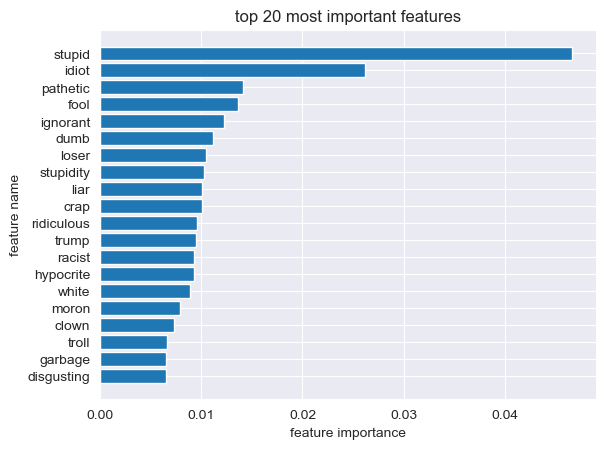

In [77]:
plt.barh(top_words[::-1], importance[::-1])
plt.xlabel('feature importance')
plt.ylabel('feature name')
plt.title('top 20 most important features')
plt.show()

отмечаем слова, которые играли большую роль еще при анализе данных -- 'trump', 'stupid'

посмотрим на слова, которую играют наименьшую роль в построении дерева

In [79]:
val_features_small_id = np.argsort(model4.best_estimator_.feature_importances_)[:20]
small_importance = model4.best_estimator_.feature_importances_[val_features_small_id]
min_words = idx2word[val_features_small_id]

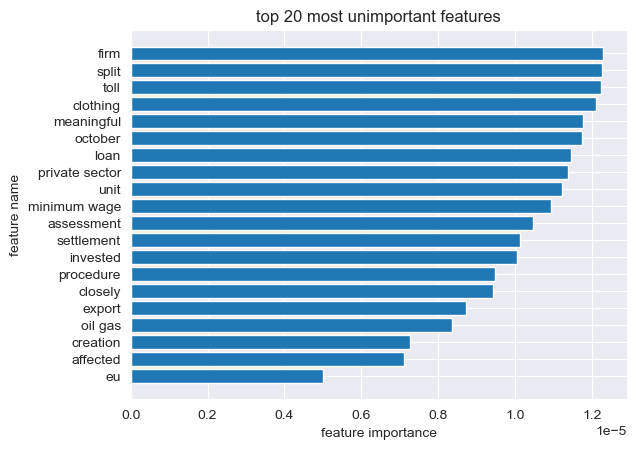

In [80]:
plt.barh(min_words, small_importance)
plt.xlabel('feature importance')
plt.ylabel('feature name')
plt.title('top 20 most unimportant features')
plt.show()

сорее всего, эти слова стречаются очень редко, поэтому мало влияют на решение

замерим время работы алгоритма

In [95]:
thr = 0.4
y_train_bin = binarize_target(y_train, thr)
y_val_bin = binarize_target(y_val, thr)
y_test_bin = binarize_target(y_test, thr)

In [105]:
%%timeit -n 3 -r 5
best_rfc = RandomForestClassifier(n_estimators=150, class_weight='balanced').fit(tfidf_train, y_train_bin)

4min 39s ± 1min 40s per loop (mean ± std. dev. of 5 runs, 3 loops each)


In [109]:
best_rfc = RandomForestClassifier(n_estimators=150, class_weight='balanced').fit(tfidf_train, y_train_bin)

In [110]:
%%timeit -n 3 -r 5
best_rfc.predict_proba(tfidf_val)

6.32 s ± 124 ms per loop (mean ± std. dev. of 5 runs, 3 loops each)
